In [1]:
import numpy as np
import pandas as pd
from itertools import combinations

In [2]:
raw_2_df = pd.read_csv("./example_2.csv")

In [3]:
def raw2base(raw_df):
    df = raw_df.copy()
    df["stock_code"] = df["stock_code"].apply(lambda x: str(x).zfill(6))
    df.set_index("stock_code", inplace=True)
    return df

##
base_df = raw2base(raw_2_df)

In [4]:
def base2main(base_df, factors, target):
    factor_df = base_df.loc[:, factors]
    target_df = base_df.loc[:, target].rename("target")
    main_df = pd.concat([factor_df, target_df], axis=1)
    return main_df


##
factors = ["cpbr", "tpbr", "ctr", "npr", "opr"]
target = "profit"
main_df = base2main(base_df, factors, target)

In [5]:
from typing import List
import pandas as pd


def analyze_factors(df: pd.DataFrame, factors: List[str], target: str, n_d: int, qct_n: int):
    # factor를 quantile 기반으로 분리한다.
    qct_factor_df = pd.concat(
        [pd.qcut(x=df[col], q=qct_n, labels=False) for col in factors], axis=1
    )
    qct_df = pd.concat([qct_factor_df, df[target]], axis=1)

    # factor를 quantile 기반으로 조합을 만든다.
    factor_combs = list(combinations(factors, n_d))
    analysis_list = []
    for factor_comb in factor_combs:
        tmp = pd.concat(
            [
                qct_df.groupby(list(factor_comb))[target].mean().rename("mean"),
                qct_df.groupby(list(factor_comb))[target].var().rename("var"),
                qct_df.groupby(list(factor_comb))[target].size().rename("count"),
            ],
            axis=1,
        )

        if n_d > 1:
            tmp["factor"] = [
                {name: index for name, index in zip(tmp.index.names, idx)} for idx in tmp.index
            ]
        else:
            tmp["factor"] = [{tmp.index.name: idx} for idx in tmp.index]
        tmp.reset_index(drop=True, inplace=True)
        analysis_list.append(tmp)
    # analysis를 반환한다.
    analysis = pd.concat(analysis_list, axis=0)
    return analysis

analysis_1d = analyze_factors(main_df, factors, "target", 1, 5)
analysis_2d = analyze_factors(main_df, factors, "target", 2, 5)

In [6]:
from sklearn.cluster import KMeans


# append_cluster
def append_cluster(analysis_df):
    kmeans = KMeans(n_clusters=3, n_init="auto", random_state=42)
    kmeans.fit(analysis_df["mean"].to_numpy().reshape(-1, 1))
    analysis_df["cluster"] = kmeans.predict(analysis_df["mean"].to_numpy().reshape(-1, 1))
    
    # sort cluster by target
    cluster_means = analysis_df.groupby("cluster")["mean"].mean().sort_values().index.tolist()
    cluster_mapping = {
        old_cluster: new_cluster for new_cluster, old_cluster in enumerate(cluster_means)
    }
    analysis_df["cluster"] = analysis_df["cluster"].map(cluster_mapping)
    return analysis_df

def format_analysis_df(analysis_df):
    analysis_df["factor_nm"] = analysis_df["factor"].apply(lambda x: list(x.keys())[0])
    analysis_df["factor_arg"] = analysis_df["factor"].apply(lambda x: list(x.values())[0])
    return analysis_df

analysis_1d = append_cluster(analysis_1d)
analysis_1d = format_analysis_df(analysis_1d)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "AppleGothic"

In [8]:
# pivot
analysis_1d_pivot_taget = analysis_1d.pivot(index=["factor_arg"], columns=["factor_nm"], values=["mean"])
analysis_1d_pivot_taget.index.name = "quantile"
analysis_1d_pivot_taget.columns = analysis_1d_pivot_taget.columns.get_level_values(1)
analysis_1d_pivot_taget = analysis_1d_pivot_taget.loc[:, factors]

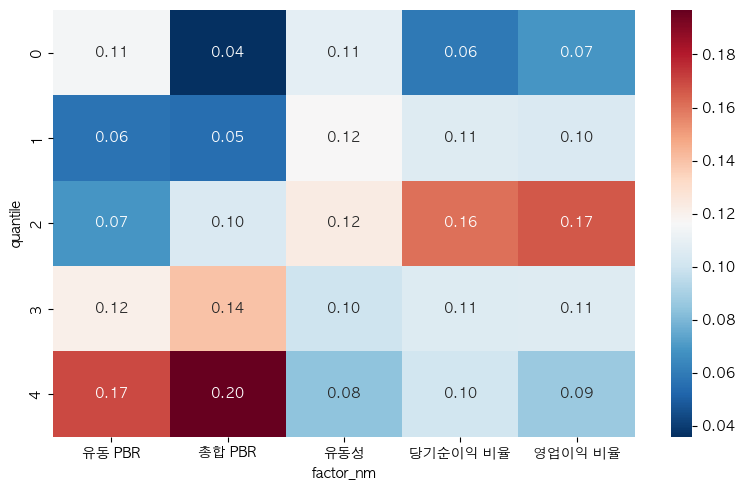

In [9]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    analysis_1d_pivot_taget.rename(
        columns={
            "cpbr": "유동 PBR",
            "tpbr": "총합 PBR",
            "ctr": "유동성",
            "npr": "당기순이익 비율",
            "opr": "영업이익 비율",
            "profit": "수익률_2달간",
        }
    ),
    fmt=".2f",
    annot=True,
    cmap="RdBu_r",
)
plt.tight_layout()
plt.show()

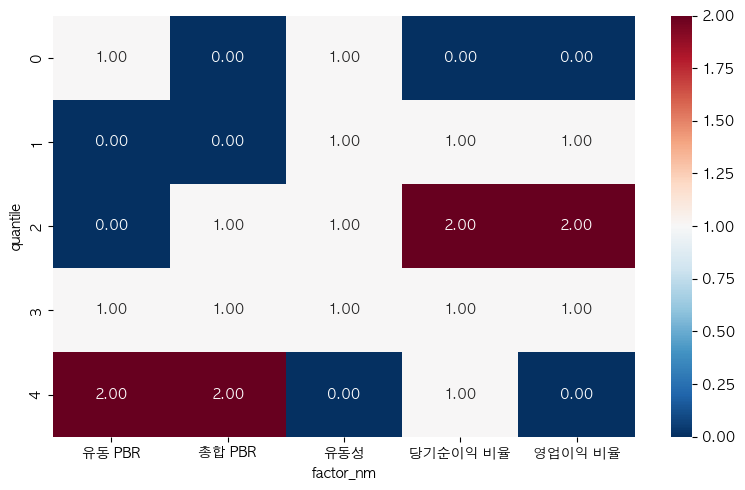

In [10]:
# pivot
analysis_1d_pivot_cluster = analysis_1d.pivot(index=["factor_arg"], columns=["factor_nm"], values=["cluster"])
analysis_1d_pivot_cluster.index.name = "quantile"
analysis_1d_pivot_cluster.columns = analysis_1d_pivot_cluster.columns.get_level_values(1)
analysis_1d_pivot_cluster = analysis_1d_pivot_cluster.loc[:, factors]

plt.figure(figsize=(8, 5))
sns.heatmap(
    analysis_1d_pivot_cluster.rename(
        columns={
            "cpbr": "유동 PBR",
            "tpbr": "총합 PBR",
            "ctr": "유동성",
            "npr": "당기순이익 비율",
            "opr": "영업이익 비율",
            "profit": "수익률_2달간",
        }
    ),
    fmt=".2f",
    annot=True,
    cmap="RdBu_r",
)
plt.tight_layout()
plt.show()

In [11]:
analysis_2d = analyze_factors(main_df, factors, "target", 2, 5)

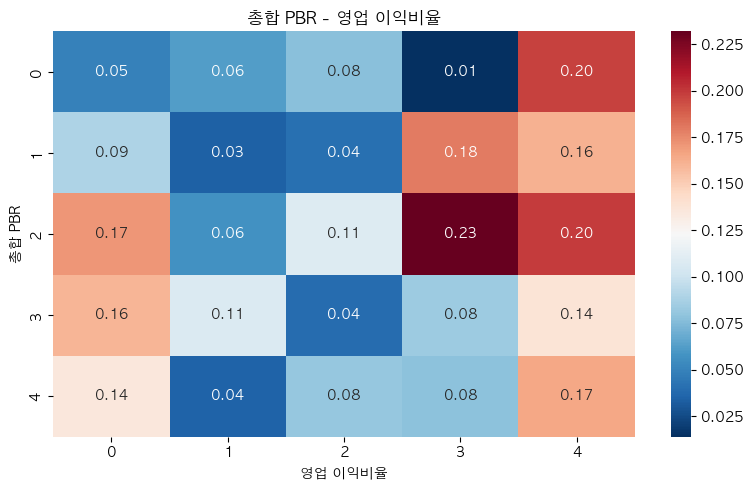

In [12]:
a, b = ["cpbr", "opr"]
_analysis_2d = analysis_2d[
    analysis_2d["factor"].apply(lambda x: (a in x.keys()) and (b in x.keys()))
].copy()
_analysis_2d[a] = _analysis_2d["factor"].apply(lambda x: x[b])
_analysis_2d[b] = _analysis_2d["factor"].apply(lambda x: x[a])
pivot_table = _analysis_2d.pivot(index=a, columns=b, values="mean")
pivot_table.index.name = "총합 PBR"
pivot_table.columns.name = "영업 이익비율"
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_table, fmt=".2f", annot=True, cmap="RdBu_r")
plt.title(f"총합 PBR - 영업 이익비율")
plt.tight_layout()
plt.show()

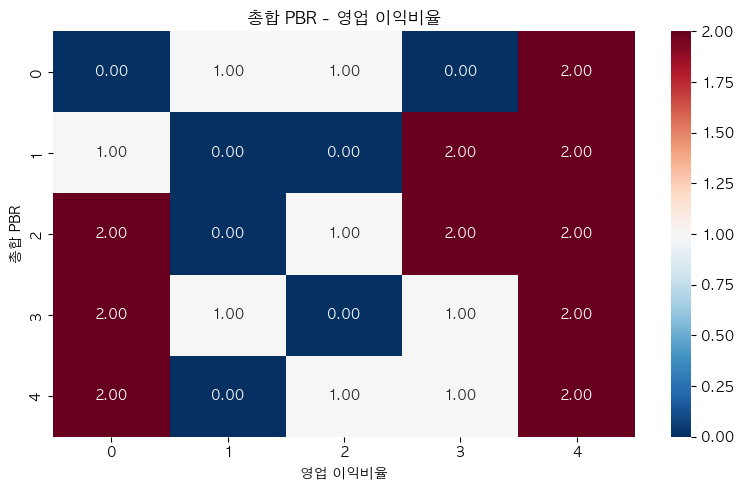

In [13]:
a, b = ["cpbr", "opr"]
_analysis_2d = analysis_2d[
    analysis_2d["factor"].apply(lambda x: (a in x.keys()) and (b in x.keys()))
].copy()
_analysis_2d[a] = _analysis_2d["factor"].apply(lambda x: x[b])
_analysis_2d[b] = _analysis_2d["factor"].apply(lambda x: x[a])

kmeans = KMeans(n_clusters=3, n_init="auto", random_state=42)
kmeans.fit(_analysis_2d["mean"].to_numpy().reshape(-1, 1))
_analysis_2d["cluster"] = kmeans.predict(_analysis_2d["mean"].to_numpy().reshape(-1, 1))
cluster_means = _analysis_2d.groupby("cluster")["mean"].mean().sort_values().index.tolist()
cluster_mapping = {
    old_cluster: new_cluster for new_cluster, old_cluster in enumerate(cluster_means)
}
_analysis_2d["cluster"] = _analysis_2d["cluster"].map(cluster_mapping)

pivot_table = _analysis_2d.pivot(index=a, columns=b, values="cluster")
pivot_table.index.name = "총합 PBR"
pivot_table.columns.name = "영업 이익비율"
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_table, fmt=".2f", annot=True, cmap="RdBu_r")
plt.title(f"총합 PBR - 영업 이익비율")
plt.tight_layout()
plt.show()